<h1 style="text-align: center">
Deep Learning HW4 </br>
Ferdousi Generator
</h1>

### Full Name: Borna khodabandeh
### Student ID: 400109898

# Ferdousi Gen

This project is for a text generator inspired by Ferdousi, which likely involves training a language model(`GPT2`) on the works of Ferdousi, the renowned Persian poet, to generate new text in a similar style or theme.

## Environment Setup


In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from os import path

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"using {device} device")

using cuda device


## Dataset Preparation

### Ferdousi Dataset Class
We define a custom dataset class `FerdousiDataset` to load the Shahnameh of Ferdousi dataset. It reads the dataset, removes metadata, and organizes the data into stanzas.

In [26]:
class FerdousiDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = self._load_data()
        
    def _load_data(self):
        with open(self.root_dir, 'r') as file:
            lines = file.readlines()
        
        # Remove metadata, split into beyts
        lines = [line.strip('\n') for line in lines]
        lines = lines[2:]
        lines = lines[0:2 * (len(lines) // 2)]
        
        # Per stanza
        data = {
            'stanza_1': lines[0::2],
            'stanza_2': lines[1::2],
            'len': len(lines) // 2,
        }

        # Per beyt
#         beyt = [stanza1 + ', ' + stanza2 for stanza1, stanza2 in zip(lines[0::2], lines[1::2])]
#         beyt = beyt[0:2 * (len(beyt) // 2)]
        
#         data = {
#             'stanza_1': beyt[0::2],
#             'stanza_2': beyt[1::2],
#             'len': len(beyt) // 2,
#         }
        
        return data

    def __getitem__(self, idx):
        if idx < len(self):
            return self.data['stanza_1'][idx], self.data['stanza_2'][idx]
        return None
    
    def __len__(self):
        return self.data['len']


### Dataset Splitting
We split the dataset into training and testing sets.

In [27]:
base_path = '/kaggle/input/ferdousi-text/ferdousi.txt'
train_test_ratio = 0.9

dataset = FerdousiDataset(base_path)

num_samples = len(dataset)
train_size = int(train_test_ratio * num_samples)
test_size = num_samples - train_size
dataset_train, dataset_test = random_split(dataset, [train_size, test_size])

# Check the dataset sizes
print(f"Number of training examples: {len(dataset_train)}")
print(f"Number of test examples: {len(dataset_test)}")

print('Samples from dataset:')

for (stanza_1, stanza_2) in dataset:
    print(f'{stanza_1 = }')
    print(f'{stanza_2 = }')
    break

Number of training examples: 44647
Number of test examples: 4961
Samples from dataset:
stanza_1 = 'به نام خداوند جان و خرد'
stanza_2 = 'کزین برتر اندیشه برنگذرد'


## Tokenization and Model Loading

We load the GPT-2 model for the Persian language (`HooshvareLab/gpt2-fa`) and initialize a tokenizer with special tokens.

In [28]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

model_name = "HooshvareLab/gpt2-fa"

special_tokens = {
#     "bos_token": '<cls>',
    "bos_token": '<s>',
#     "eos_token": '<sep>',
    "eos_token": '</s>',
    "unk_token": '<unk>',
    "pad_token": '<pad>',
    "sep_token": '<sep>'
}

opt = {
    **special_tokens,
    "padding_side": "right", # Persian 
    "model_max_length": 20, # chosen by viewing the dataset
    "model_name": model_name,
}

tokenizer = AutoTokenizer.from_pretrained(model_name, **opt)

tokenizer.add_special_tokens(special_tokens)

config = AutoConfig.from_pretrained(model_name, **tokenizer.special_tokens_map)

print(f'Vocab size: {len(tokenizer)}')
tokenizer.special_tokens_map

Vocab size: 42001


{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '<sep>',
 'pad_token': '<pad>'}

### TokenizedFerdousiDataset Class

We create a tokenized version of the dataset using the tokenizer. The `TokenizedFerdousiDataset` class tokenizes each stanza pair, preparing the data for model training.

In [29]:
from tqdm import tqdm

class TokenizedFerdousiDataset(Dataset):
    def __init__(self, ferdousiDataset, tokenizer):
        self.tokenizer = tokenizer
        self.ferdousiDataset = ferdousiDataset
        
        self.encodings = {
            'input_ids': [],
            'labels': [],
            'attention_mask': [],
        }
        
        for (stanza_1, stanza_2) in tqdm(ferdousiDataset, desc='Tokenizing'):
            input_enc = tokenizer(
#                 tokenizer.bos_token + stanza_1 + tokenizer.eos_token, # Normal
                tokenizer.bos_token + stanza_1 + tokenizer.sep_token + stanza_2 + tokenizer.eos_token, # Masked autoencoder
                truncation=True,
                padding="max_length"
            )

            target_enc = tokenizer(
#                 tokenizer.bos_token + stanza_2 + tokenizer.eos_token, # Normal
                tokenizer.bos_token + stanza_1 + tokenizer.sep_token + stanza_2 + tokenizer.eos_token, # Masked autoencoder
                truncation=True,
                padding="max_length"
            )
            
            self.encodings['input_ids'].append(torch.tensor(input_enc['input_ids']))
            self.encodings['labels'].append(torch.tensor(target_enc['input_ids']))
            self.encodings['attention_mask'].append(torch.tensor(input_enc['attention_mask']))

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'labels': self.encodings['labels'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
        }

    def __len__(self):
        return len(self.ferdousiDataset)


### Creating dataloaders

here we create suitable dataloaders for the training and testing phase of our program.

we also sample some of the values to visualize the actual dataset.

In [30]:
tokenized_dataset_train = TokenizedFerdousiDataset(dataset_train, tokenizer)
tokenized_dataset_test = TokenizedFerdousiDataset(dataset_test, tokenizer)

batch_size = 128

train_dataloader = DataLoader(
    tokenized_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=False
)
test_dataloader = DataLoader(
    tokenized_dataset_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=False
)

if os.cpu_count() > 1:
    os.environ["TOKENIZERS_PARALLELISM"] = "true"

print('Samples from dataloader:')
for encoding in train_dataloader:
    input_ids = encoding['input_ids']
    target_ids = encoding['labels']
    print(f'{input_ids[0].shape = }')
    input_stanza_original = tokenizer.decode(input_ids[0])
    print(f'{input_stanza_original = }')
    input_stanza_clean = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    target_stanza_clean = tokenizer.decode(target_ids[0], skip_special_tokens=True)
    print(f'{input_stanza_clean = }')
    print(f'{target_stanza_clean = }')
    poem = input_stanza_clean + ' , ' + target_stanza_clean
    print(f'{poem = }')
    break

Tokenizing: 100%|██████████| 4961/4961 [00:01<00:00, 2900.75it/s]

Samples from dataloader:


input_ids[0].shape = torch.Size([20])
input_stanza_original = '<s>چه دانی تو پیران و کلباد را<sep>گروی زره را و پولاد را</s><pad><pad>'
input_stanza_clean = 'چه دانی تو پیران و کلباد راگروی زره را و پولاد را'
target_stanza_clean = 'چه دانی تو پیران و کلباد راگروی زره را و پولاد را'
poem = 'چه دانی تو پیران و کلباد راگروی زره را و پولاد را , چه دانی تو پیران و کلباد راگروی زره را و پولاد را'


## Loading the model

here we load the actual `GPT2LMHeadModel` for text generation, fitting it to our now modified tokenizer.

In [31]:
model = AutoModelForCausalLM.from_config(config)

model.resize_token_embeddings(len(tokenizer))
model = model.to(device)

parallel = torch.cuda.device_count() > 1

if parallel:
    model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(42001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=42001, bias=False)
)

### Sampling untrained model output

In [32]:
model.train()

for encoding in train_dataloader:
    encoding = {k:v.to(device) for k, v in encoding.items()}
    encoding.pop('labels')
    encoding['attention_mask'] = torch.ones_like(encoding['attention_mask']).to(device)
    gen = model.module if parallel else model
    outputs = gen.generate(
        **encoding,
        top_k=50,
        max_length=25,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    in_stanza = tokenizer.decode(encoding['input_ids'][0], skip_special_tokens=True)
    out_stanza = tokenizer.decode(outputs[0], skip_special_tokens=True)
    out_stanza = out_stanza.replace(in_stanza, '')
    print('Input sequence: ')
    print(in_stanza)
    print('Output sequence: ')
    print(out_stanza)
    break

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Input sequence: 
همه داستان سیاوش بگفتکه او را ز شاهان کسی نیست جفت
Output sequence: 
 هلیکوپترهای دارویی دارویی بطوریکه بوعلی


### Simple function to calculate BLEU score

In [33]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(output, reference):
    output_tokens = tokenizer.decode(output, skip_special_tokens=True)
    reference_tokens = tokenizer.decode(reference, skip_special_tokens=True)
    reference_words = nltk.word_tokenize(reference_tokens)
    output_words = nltk.word_tokenize(output_tokens)

    # Compute BLEU score
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu([reference_words], output_words, smoothing_function=smoothie)
    return bleu_score

hypothesis = tokenizer.encode('This is cat cat who love')
reference = tokenizer.encode('This is a cat who i love')
print(hypothesis)
BLEUscore = compute_bleu(hypothesis, reference)
print(BLEUscore)

[14943, 2433, 7557, 2578, 1276, 2578, 1276, 30436, 40981]
0.28025982377627073


## Model Training

The model is trained, and the training loss is plotted over epochs.
and each epoch we sample a random stanza and see the models prediction to visualize the training process's effect on the model generation.

In [34]:
num_epochs = 8
loss_dict = {'train_losses': [], 'val_losses': [], 'gen_bleu': [], 'perplexity': []}

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for encoding in tqdm(train_dataloader, desc=f"Training loop {epoch+1}/{num_epochs}"):
        encoding = {k:v.to(device) for k, v in encoding.items()}
        encoding['attention_mask'] = torch.ones_like(encoding['attention_mask']).to(device)
#         outputs = model(**encoding, token_type_ids=None)
        outputs = model(
            input_ids=encoding['input_ids'], labels=encoding['labels'], attention_mask=encoding['attention_mask'],
            token_type_ids=None,
        )
        loss = outputs.loss
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         break
        
    avg_train_loss = total_train_loss / len(train_dataloader)
    loss_dict['train_losses'].append(avg_train_loss)
    
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_encoding in tqdm(test_dataloader, desc=f"Validation loop {epoch+1}/{num_epochs}"):
            val_encoding = {k: v.to(device) for k, v in val_encoding.items()}
            val_encoding['attention_mask'] = torch.ones_like(val_encoding['attention_mask']).to(device)
#             val_outputs = model(**val_encoding, token_type_ids=None)
            val_outputs = model(
                input_ids=val_encoding['input_ids'], labels=val_encoding['labels'], 
                attention_mask=val_encoding['attention_mask'],
                token_type_ids=None,
            )
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()
#             break

        # Generate one sample
        print('generating sample: ')
        for stanza_1, stanza_2 in dataset_test:
            input_ids = tokenizer(
#                 tokenizer.bos_token + stanza_1 + tokenizer.eos_token, # Normal
                tokenizer.bos_token + stanza_1 + tokenizer.sep_token, # Masked autoencoder
                truncation=True,
                padding="max_length",
                return_tensors='pt'
            )['input_ids'].to(device)
            labels = tokenizer(
#                 tokenizer.bos_token + stanza_2 + tokenizer.eos_token, # Normal
                tokenizer.bos_token + stanza_1 + tokenizer.sep_token + stanza_2 + tokenizer.eos_token, # Masked autoencoder
                truncation=True,
                padding="max_length",
                return_tensors='pt'
            )['input_ids'].to(device)
            outputs = gen.generate(
#                 **gen_encoding,
                input_ids=input_ids,
                attention_mask=torch.ones_like(input_ids).to(device),
                top_k=50,
                max_length=30,
                num_beams=5,
                no_repeat_ngram_size=2,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id, # Open end generation
            )
            in_stanza = stanza_1
            out_stanza = tokenizer.decode(outputs[0], skip_special_tokens=True)
            out_stanza = out_stanza.replace(in_stanza, in_stanza + ' , ')
            bleu = compute_bleu(outputs[0], labels[0])
            loss_dict['gen_bleu'].append(bleu)
            loss = gen(input_ids, labels=labels).loss
            perplexity = (torch.exp(loss).item())
            loss_dict['perplexity'].append(perplexity)
            print('Input sequence: ')
            print(in_stanza)
            print('Output sequence: ')
            print(out_stanza)
            print(f'{bleu = }, {perplexity = }')
            break

    avg_val_loss = total_val_loss / len(test_dataloader)
    loss_dict['val_losses'].append(avg_val_loss)

Validation loop 1/8: 100%|██████████| 39/39 [00:04<00:00,  8.43it/s]


generating sample: 
بیفشارد ران لشکر کینه خواه
Input sequence: 
بیفشارد ران لشکر کینه خواه
Output sequence: 
بیفشارد ران لشکر کینه خواه , 
bleu = 0.24601580968354606, perplexity = 656.1782836914062


Validation loop 2/8: 100%|██████████| 39/39 [00:04<00:00,  8.43it/s]


generating sample: 
بیفشارد ران لشکر کینه خواه
Input sequence: 
بیفشارد ران لشکر کینه خواه
Output sequence: 
بیفشارد ران لشکر کینه خواه , 
bleu = 0.24601580968354606, perplexity = 584.4558715820312


Validation loop 3/8: 100%|██████████| 39/39 [00:04<00:00,  8.44it/s]


generating sample: 
بیفشارد ران لشکر کینه خواه
Input sequence: 
بیفشارد ران لشکر کینه خواه
Output sequence: 
بیفشارد ران لشکر کینه خواه , 
bleu = 0.24601580968354606, perplexity = 129.62411499023438


Validation loop 4/8: 100%|██████████| 39/39 [00:04<00:00,  8.44it/s]


generating sample: 
بیفشارد ران لشکر کینه خواه
Input sequence: 
بیفشارد ران لشکر کینه خواه
Output sequence: 
بیفشارد ران لشکر کینه خواه , 
bleu = 0.24601580968354606, perplexity = 77.34866333007812


Validation loop 5/8: 100%|██████████| 39/39 [00:04<00:00,  8.45it/s]


generating sample: 
بیفشارد ران لشکر کینه خواه
Input sequence: 
بیفشارد ران لشکر کینه خواه
Output sequence: 
بیفشارد ران لشکر کینه خواه , 
bleu = 0.24601580968354606, perplexity = 76.479248046875


Validation loop 6/8: 100%|██████████| 39/39 [00:04<00:00,  8.49it/s]


generating sample: 
بیفشارد ران لشکر کینه خواه
Input sequence: 
بیفشارد ران لشکر کینه خواه
Output sequence: 
بیفشارد ران لشکر کینه خواه ,  از
bleu = 0.2608840516436559, perplexity = 38.72962951660156


Validation loop 7/8: 100%|██████████| 39/39 [00:04<00:00,  8.49it/s]


generating sample: 
بیفشارد ران لشکر کینه خواه
Input sequence: 
بیفشارد ران لشکر کینه خواه
Output sequence: 
بیفشارد ران لشکر کینه خواه , اندر
bleu = 0.24601580968354606, perplexity = 38.94485855102539


Validation loop 8/8: 100%|██████████| 39/39 [00:04<00:00,  8.47it/s]

generating sample: 
بیفشارد ران لشکر کینه خواه
Input sequence: 
بیفشارد ران لشکر کینه خواه
Output sequence: 
بیفشارد ران لشکر کینه خواه ,  از
bleu = 0.2608840516436559, perplexity = 59.41371536254883


we can see clearly how the generated text becomes more and more similar to the original shahnameh as training goes on

#### Saving the model

In [35]:
torch.save(model.state_dict(), "ferdousi.pth")

#### Plotting loss over epochs

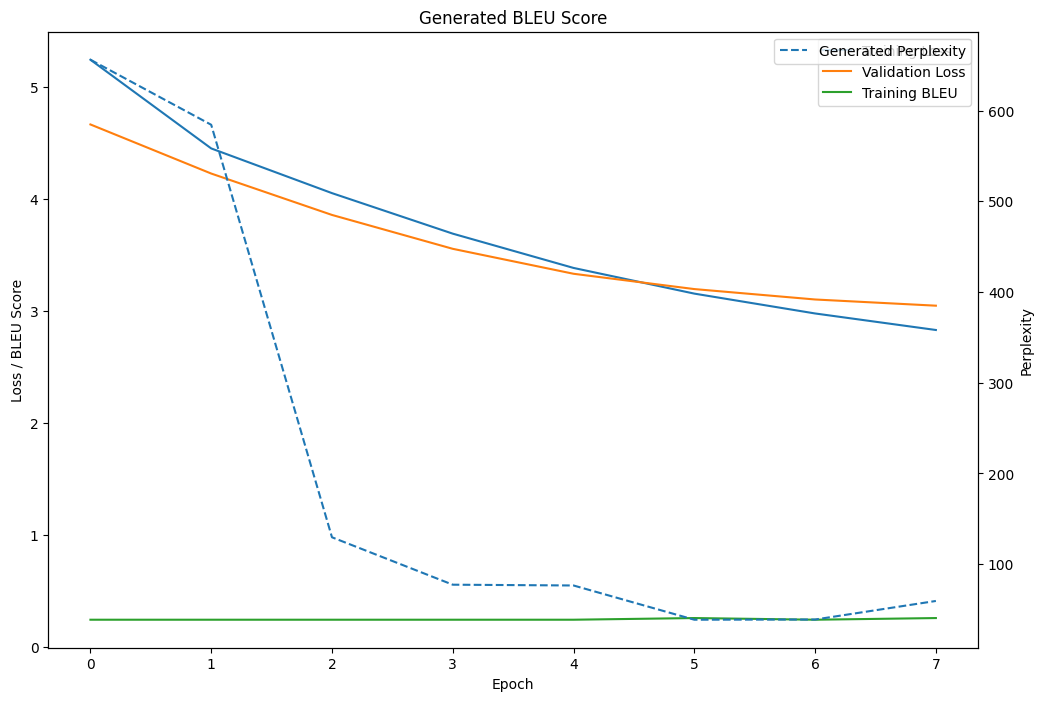

In [36]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(12, 8))

# Plot loss
ax.plot(loss_dict['train_losses'], label='Training Loss')
ax.plot(loss_dict['val_losses'], label='Validation Loss')

# Plot BLEU scores
ax.plot(loss_dict['gen_bleu'], label='Training BLEU')

ax.set_title('Generated BLEU Score')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss / BLEU Score')
ax.legend()

# plot perplexity
ax2 = ax.twinx()
ax2.plot(loss_dict['perplexity'], label='Generated Perplexity', linestyle='dashed')
ax2.set_ylabel('Perplexity')
ax2.legend()

plt.show()


## Model Evaluation

We define a function to compute BLEU scores for generated stanzas compared to reference stanzas. We then generate and evaluate poems based on a few input prompts.

In [41]:
poems = [
    'میازار موری که داته کش است',
    'به نام خداوند جان و خرد',
    'که اخذ کرد او دیپ با فاطمی',
    'چون سنگها صدای مرا گوش می کنی',
    'از دام بوسه راه گریزی اگر که بود',
    'گل من را اذیت نکنین',
    'توانا بود هرکه دانا بود',
    'چو زین بگذری مردم آمد پدید',
]

for poem in poems:
    gen_encoding = {'input_ids': 0, 'attention_mask': 0}
    input_ = tokenizer(
        tokenizer.bos_token + poem + tokenizer.sep_token , # Masked auto encoder
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )
    gen_encoding['input_ids'] = input_["input_ids"].to(device)
    gen_encoding['attention_mask'] = torch.ones_like(gen_encoding['input_ids']).to(device)
    gen = model.module if parallel else model
    outputs = gen.generate(
        **gen_encoding,
        top_k=50,
        max_length=30,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=1,
        do_sample = False,
        pad_token_id=tokenizer.eos_token_id, # Open end generation
    )
    in_stanza = tokenizer.decode(gen_encoding['input_ids'][0], skip_special_tokens=True)
    out_stanza = tokenizer.decode(outputs[0], skip_special_tokens=True)
    out_stanza = out_stanza.replace(in_stanza, in_stanza + '  ,  ')
    print('Generated sequence: ')
    print(out_stanza)
    
#     target_array = input_["input_ids"].cpu().numpy().flatten()
#     output_array = outputs.cpu().numpy().flatten()
#     bleu_score = compute_bleu(output_array, target_array)
#     print(f'BLEU Score: {bleu_score:.4f}\n')

Generated sequence: 
میازار موری که داته کش است  ,   سپنجست از نهان بر تخت از بر
Generated sequence: 
به نام خداوند جان و خرد  ,   سپنج و کمند و کلاه از هنر پرورد
Generated sequence: 
که اخذ کرد او دیپ با فاطمی  ,   سپنجستست و کمندست از بر
Generated sequence: 
چون سنگها صدای مرا گوش می کنی  ,   از بر تخت و کلاه من افسر و بوی و
Generated sequence: 
از دام بوسه راه گریزی اگر که بود  ,   از بر خاکست وتر چیزست ازو
Generated sequence: 
گل من را اذیت نکنین  ,   سپنجست از بر سر تخت شاهی تراست
Generated sequence: 
توانا بود هرکه دانا بود  ,   از بر سر تخت و افسرش افسر بود
Generated sequence: 
چو زین بگذری مردم آمد پدید  ,   از بر سر تخت از نهان افسر دید
